<a href="https://colab.research.google.com/github/saharshayegan/Twitter_LDA_text_analysis/blob/main/English_Twitter_LDA_TextAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Run this and reset the runtime. Then proceed.
!pip install --upgrade pandas==1.2
!pip install -U gensim

## Installing and importing

In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords

from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel, LsiModel
from gensim.models.ldamodel import LdaModel
from gensim import corpora
from gensim import matutils

from collections import defaultdict
import pickle

/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]
/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio5.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .mio5_utils import VarReader5
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### Installing Stuff

In [ ]:
# Package is in detached-head mode. Clone from Github, commit latest changes and run setup.py
! git clone https://github.com/bmabey/pyLDAvis
%cd pyLDAvis
! python setup.py build
! python setup.py install
%cd ..

In [ ]:
! python3.7 -m pip install funcy
! pip install funcy
import sys
sys.path.insert(0,'/usr/local/lib/python3.7/dist-packages/funcy-1.17-py3.7.egg')
import funcy
# !pip install --upgrade pandas==1.2


import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
import pyLDAvis.gensim_models as gensimvis

ModuleNotFoundError: ignored

Load Twitter batch. File has 6 tab delimited columns

## Base

In [3]:
import pandas as pd

filename= "/content/drive/MyDrive/Colab Notebooks/thesis/diseases.txt"
with open(filename) as f:
    diseases = [line.rstrip() for line in f]
print(diseases)

path = r'/content/drive/MyDrive/Colab Notebooks/thesis/' # use your path

# disease = diseases[0]

['COPD', 'Diabetes', 'Arthritis', 'Obesity', 'Migraine', 'Heart Diseases', 'Asthma', 'Depression', 'PTSD', 'Cancer']


## Text preparation/cleanup for analysis

In [ ]:
# I've run this before. don't run it again.
for disease in diseases:
  print(disease)
  df = pd.read_csv(path+disease+'_tweets.csv', index_col=None, header=0)
  tweet_list_raw = df['Text'].tolist()
  # Text cleaning
  # Remove http
  link_pttrn = r"http\S+"
  tweet_list = [re.sub(link_pttrn, "", tweet) for tweet in tweet_list_raw]

  # Remove non-letter sequences
  nl_pttrn = r"[^a-zA-Z']+"
  tweet_list = [re.sub(nl_pttrn, " ", tweet) for tweet in tweet_list]

  # Lower case
  tweet_list = [tweet.lower() for tweet in tweet_list]

  # Remove white space at beginning and end of document
  ws_pttrn = r"(^ | $)"
  tweet_list = [re.sub(ws_pttrn, "", tweet) for tweet in tweet_list]
  # tweet_list[10:20]
  # Pre-processing
  # print(tweet_list_raw[501])
  # Post-processing
  # print(tweet_list[501])


  import nltk
  # STOPWORDS
  nltk_stop_words = set(stopwords.words("english"))
  def tokenize(tweet):
      return [token for token in simple_preprocess(tweet) if token not in nltk_stop_words]
  tweets = [tokenize(tweet) for tweet in tweet_list]
  tweets
  tweets[501]
  frequency = defaultdict(int)
  for tweet in tweets:
      for token in tweet:
          frequency[token] += 1
  freq_series = pd.Series(frequency)
  # freq_series.sort_values(ascending=False)[0:10]
  days = ['mon','tue','wed','thu','fri','sat','sun']
  months = ['jan', 'feb', 'mar','apr','may','jun',\
          'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

  irrel = ["rt", "amp"]
  uncommon_words = [w[0] for w in frequency.items() if w[1]<5]
  two_letter = [w[0] for w in frequency.items() if len(w[0])< 3]

  removed = uncommon_words + two_letter +days + months + irrel  
  print('Text is cleaned')

  # Process does take about 10-15 minutes, so the output is saved and loaded
  tweets_clean = [[token for token in tweet if token not in removed] for tweet in tweets]
  tweets_clean[501]
  pickle_out = open(path+disease+"_clean_final.pickle", "wb")
  pickle.dump(tweets_clean, pickle_out)
  pickle_out.close()

## LDA and Visualization

### The LDA and Visualize methods

In [ ]:
def run_lda(corpus, dictionary, clusters,path,disease):
  # Runtime about 5 mins
  print('Trying to run the models')
  tweet_topics = LdaModel(corpus = corpus,
                        id2word = dictionary,
                        num_topics = clusters,
                        passes= 10)
  pickle_out2 = open(path+disease+"_ffinalmodel_{}clusters.pickle".format(clusters), "wb")
  pickle.dump(tweet_topics, pickle_out2)
  pickle_out2.close()
  return tweet_topics

In [ ]:
def visualize(tweet_topics, corpus, dictionary, clusters, path, disease):
  ### Visualizing
  vis_data = gensimvis.prepare(tweet_topics, corpus, dictionary)
  # print(vis_data)
  file = open(path+disease+'_twitter-LDA_{}clusters.txt'.format(clusters), 'w')
  file.write(str(vis_data))
  file.close()
  import pyLDAvis
  pyLDAvis.display(vis_data)
  pyLDAvis.save_html(vis_data, path+disease+'_twitter-LDA_{}clusters.html'.format(clusters))

### For each topic:

In [ ]:
for disease in diseases:
  import pickle
  tweets_clean = pickle.load(open(path+disease+"_clean_final.pickle", "rb" ) )
  tweets_clean[501]
  dictionary = corpora.Dictionary(tweets_clean)
  corpus = [dictionary.doc2bow(tweet) for tweet in tweets_clean]


  #Run batch LDA and cross fingers
  clusters = 4

  run_lda(corpus, dictionary, clusters,path,disease)

  tweet_topics = pickle.load(open(  path+disease+"_ffinalmodel_{}clusters.pickle".format(clusters), "rb" ) )
  for i, topic in enumerate(tweet_topics.print_topics(15)):
      print (i, topic)

  ### INSTALLING STUFF WAS HERE

  ### Visualizing
  visualize(tweet_topics, corpus, dictionary, clusters, path, disease)


0 (0, '0.073*"copd" + 0.038*"disease" + 0.030*"chronic" + 0.029*"pulmonary" + 0.022*"patients" + 0.021*"obstructive" + 0.016*"risk" + 0.010*"study" + 0.010*"lung" + 0.010*"smoking"')
1 (1, '0.059*"copd" + 0.012*"asthma" + 0.010*"register" + 0.010*"march" + 0.009*"conference" + 0.008*"join" + 0.007*"available" + 0.006*"nursing" + 0.006*"respiratory" + 0.006*"research"')
2 (2, '0.084*"copd" + 0.026*"asthma" + 0.013*"lung" + 0.010*"help" + 0.010*"respiratory" + 0.009*"health" + 0.009*"patients" + 0.009*"treatment" + 0.008*"new" + 0.008*"people"')
3 (3, '0.066*"copd" + 0.027*"covid" + 0.011*"get" + 0.009*"people" + 0.007*"like" + 0.007*"cancer" + 0.007*"know" + 0.006*"got" + 0.006*"hospital" + 0.006*"heart"')


NameError: ignored

In [ ]:
!pip install -U gensim

In [ ]:
import pickle
disease = 'COPD'
clusters = 3

tweets_clean = pickle.load(open(path+disease+"_clean_final.pickle", "rb" ) )
dictionary = corpora.Dictionary(tweets_clean)
corpus = [dictionary.doc2bow(tweet) for tweet in tweets_clean]

lda_model = pickle.load(open(  path+disease+"_ffinalmodel_{}clusters.pickle".format(clusters), "rb" ) )
perplexity = lda_model.log_perplexity(corpus)

In [ ]:
print(perplexity)

-7.070407183057969
-7.105437433571481


### For all topics together

In [ ]:
import pandas as pd
import pickle

path = r'/content/drive/MyDrive/Colab Notebooks/thesis/' # use your path

all_tweets = []

for disease in diseases:
  tweets = pickle.load(open(path+disease+"_clean_final.pickle", "rb" ) )
  all_tweets+= tweets

dictionary = corpora.Dictionary(all_tweets)
corpus = [dictionary.doc2bow(tweet) for tweet in all_tweets]
clusters = 6

lda_model = run_lda(corpus, dictionary, clusters,path,'all')

visualize(lda_model, corpus, dictionary, clusters, path, 'all')

# TFIDF


### YOU NEED TEST AND TRAIN DATA.

In [8]:
import pickle
import numpy as np
import pandas as pd 
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer

for disease in ['COPD']:#diseases:
  tweets_clean = pickle.load(open(path+disease+"_clean_final.pickle", "rb" ) )

  # You need to change the cleaning process. 
  # or concatinate the tokens to create the entences. 
  # this will not work with tokens. it gets a column of sentences in your df.
  text_content = tweets_clean
  for i in range(len(text_content)):
    s = ''
    for token in text_content[i]:
      s += token + ' '
    text_content[i] = s
  vector = TfidfVectorizer(stop_words = 'english') #Dont need stop words
  tfidf = vector.fit_transform(text_content)
  print(text_content[0:10])

['pulm wtchp cce stony brook first responder medical records drs notes discussing social history smoker smoker copd last yrs wrote many final reports shared ', 'would say prayer father triple year ago still dealing severe nerve pain also copd broke rib coughing prayers definitely needed tired seeing dad much pain ', 'airway clinical research center research programs asthma copd sarcoidosis cystic fibrosis along current programs sponsored nih pharmaceutical industry position ', 'differentiating asthma copd imaging machine pulmonology machinelearning ', 'clinical implications bronchodilator testing diagnosing differentiating copd asthma copd overlap ', 'chronic depression high blood pressure chronic asthma bronchitis copd alot ', 'person copd feels self conscious bringing oxygen hearts child best way strike conversation daughter law ', 'able walk around easier another days back able get things done remember much last week except hell plus finally quit smoking days never period scary shit

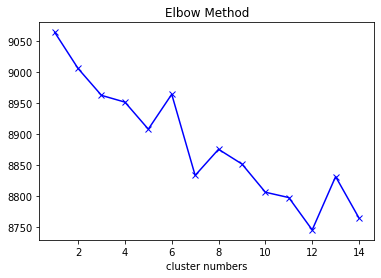

In [9]:
## YOU SHOULD ALSO DO ALL THE REST FOR EACH TOPIC

# 3. Using elbow method to decide cluster number
# Introduction to elbow method

K = range(1,15)
SSE = []
for k in K:
    kmeans = MiniBatchKMeans(n_clusters = k,batch_size = 300)
    kmeans.fit(tfidf)
    SSE.append(kmeans.inertia_)
    
import matplotlib.pyplot as plt
plt.plot(K,SSE,'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [10]:
# 5. Using MiniBatchKMean to cluster
# Comparison of the K-Means and MiniBatchKMeans clustering algorithms

k = 4
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names()

for i in range(0,k):
    word_list=[]
    print("cluster%d:"% i)
    for j in centers[i,:15]:
        word_list.append(terms[j])
    print(word_list) 

cluster0:
['covid', 'copd', 'mom', 'got', 'home', 'hospital', 'dad', 'mask', 'old', 'years', 'positive', 'time', 'year', 'people', 'tested']
cluster1:
['asthma', 'copd', 'disease', 'chronic', 'obstructive', 'lung', 'pulmonary', 'used', 'patients', 'respiratory', 'treat', 'treatment', 'diseases', 'bronchitis', 'rotacaps']
cluster2:
['copd', 'help', 'patients', 'disease', 'lung', 'pulmonary', 'people', 'health', 'study', 'smoking', 'chronic', 'risk', 'new', 'care', 'like']
cluster3:
['know', 'living', 'copd', 'youtube', 'people', 'lung', 'like', 'let', 'need', 'conditions', 'disease', 'fiberglass', 'friends', 'asthma', 'support']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [13]:
# 7. Topic modeling

# Here I use NMF instead of LDA because LDA's calculation is time-consuming.

# The major topics consist of politics, society, finance and internetional affairs, which is quite similiar to our cluster resu

from sklearn.decomposition import NMF

nmf  = NMF(n_components = 4)
nmf.fit(tfidf)
for i in range(0,k):
    word_list=[]
    print("Topic%d:"% i)
    for j in nmf.components_.argsort()[i,-16:-1]:
        word_list.append(terms[j])
    print(word_list)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic0:
['learn', 'today', 'risk', 'new', 'care', 'know', 'like', 'cancer', 'patients', 'health', 'asthma', 'lung', 'people', 'help', 'covid']
Topic1:
['cancer', 'common', 'causes', 'heart', 'rehabilitation', 'respiratory', 'copd', 'smoking', 'bronchitis', 'emphysema', 'diseases', 'lung', 'obstructive', 'pulmonary', 'disease']
Topic2:
['rotahaler', 'tiova', 'device', 'capsules', 'dry', 'treat', 'inhalation', 'approves', 'powder', 'cipla', 'symbicort', 'treatment', 'fda', 'generic', 'rotacaps']
Topic3:
['rotacaps', 'disease', 'obstructive', 'treat', 'patients', 'years', 'airway', 'older', 'age', 'prevent', 'reversible', 'prevention', 'asthalin', 'bronchospasm', 'inhaler']


## Determine time evolution of tweets

In [ ]:
# extract all document-topic distritbutions to dictionnary
# document_key = list(tweet_df.date)
document_topic = {}

In [ ]:
for doc_id in range(len(corpus)):
    docbok = corpus[doc_id]
    doc_topics = tweet_topics.get_document_topics(docbok, 0)
    tmp = []
    for topic_id, topic_prob in doc_topics:
        tmp.append(topic_prob)
    document_topic[document_key[doc_id]] = tmp

In [ ]:
df = pd.DataFrame.from_dict(document_topic, orient='index')

In [ ]:
df.columns = ["Nuclear", "Professor_Crime", "Thaler_Nobel", "Cancer_Research", "Unionization", "Evening_Program", "Zimmer_FreeSpeech"]

In [ ]:
df.head(5)

In [ ]:
df.to_csv("/Users/Orest/Desktop/Big Data and Text Analytics/FP/timed_tweets.csv")

Graphs are produced with ggplot2 package in R.